In [179]:
import math
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as Data
from torch.utils.data import Dataset as Dataset
from torch.utils.data import DataLoader, SubsetRandomSampler
from matplotlib import pyplot as plt
from torchvision import datasets, transforms
from datetime import datetime
from typing import Optional, TextIO
import sys

## Experimental

In [180]:
def normalized_euclidean_distance_between_tensors(t1, t2):
    vec1 = image1.view(-1)
    vec2 = image2.view(-1)
    return torch.sum(torch.abs((vec2 - vec1)))/vec1.shape[0]

In [181]:
class LeNet5AutoEncoder(nn.Module):

    def __init__(self, latent_size=5):
        
        super(LeNet5, self).__init__()
        
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.Tanh()
        )
        
        self.feature_compressor = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=latent_size*2)
        )
        
        self.feature_expander = nn.Sequential(
            nn.Linear(in_features=latent_size, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=120),
            nn.Tanh()
        )
        
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(in_channels=120, out_channels=16, kernel_size=5, stride=1),
            nn.MaxUnpool2d(kernel_size=2),
            nn.Tanh(),
            nn.ConvTranspose2d(in_channels=16, out_channels=6, kernel_size=5, stride=1),
            nn.MaxUnpool2d(kernel_size=2),
            nn.Tanh(),
            nn.ConvTranspose2d(in_channels=6, out_channels=1, kernel_size=5, stride=1)
        )
    
    def encode(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1) # this is just the technical tensor reshaping. The *actual* flattening is the last 
                                # layer of the feature_extractor, which uses convolution to take the 5x5 feature maps into a single 1x1 value.
        logits = self.feature_compressor(x)
        return logits, probabilities
    
    def reparameterise(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = std.new_empty(std.size()).normal_()
            return eps.mul_(std).add_(mu)
        else:
            return mu

    def decode(self, z):
        z = self.feature_expander(z)
        z = z.unsqueeze(2).unsqueeze(2) # Changing structure: flat->channels. Required for ConvTranspose
        return self.deconv(z)
    
    def forward(self, x):
        mu_and_logvar = self.encode(x).view(-1, 2, d)
        mu = mu_logvar[:, 0, :]
        logvar = mu_logvar[:, 1, :]
        z = self.reparameterise(mu, logvar)
        return self.decode(z), mu, logvar
    
    


In [182]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)
    
NoiseTransform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    AddGaussianNoise(0., 1.)
])

## NN Utilities

In [183]:
def plot_losses_over_epochs(train_losses: list[float], valid_losses: list[float]):
    '''
    Graphically show the training and validation loss for each epoch.
    '''
    
    # temporarily change the style of the plots to seaborn 
    plt.style.use('seaborn')

    train_losses = np.array(train_losses) 
    valid_losses = np.array(valid_losses)

    fig, ax = plt.subplots(figsize = (8, 4.5))

    ax.plot(train_losses, color='blue', label='Training loss') 
    ax.plot(valid_losses, color='red', label='Validation loss')
    ax.set(title="Loss over epochs", 
            xlabel='Epoch',
            ylabel='Loss') 
    ax.legend()
    fig.show()
    
    # change the plot style to default
    plt.style.use('default')

In [184]:
def run_single_epoch(loader, criterion, model, optimizer, normalize_input_fn, normalize_labels_fn, positive_class = 1, train=True):
    '''
    Implementation a single epoch for the training/validation loop.
    '''        
    
    model.train() if train else model.eval() 
    
    running_loss = 0
    
    # Each iteration gets a batch from the train loader
    for X, Y_true in loader:
        X = normalize_input_fn(X) # Normalizing the input if necessary
        X = X.to(DEVICE)
        Y_true = Y_true.to(DEVICE)
        # Y_true = normalize_labels_fn(Y_true)
        # Y_true[Y_true == positive_class]  = 1 # We "normalize" the label of the positive class to be "1". Makes our lives easier (see comment below)
        
        optimizer.zero_grad() if train else None
        
        # Forward pass
        Y_logits, Y_prob = model(X)
        _, predicted_labels = torch.max(Y_prob, 1)  # The "1" is acutally misleading - it's the dimension to search the max in.
                                                        # This actually returns the indices of the highest prediction for each row, 
                                                        # but since the index is one-to-one with the predicted digit (i.e., 0 or 1), 
                                                        # we use the index of the max probability as the label that's being predicted
        batch_loss = criterion(Y_logits, Y_true) # we use the logits as the parameter since "CELoss already pefroms softmax internally.
        running_loss += batch_loss.item() * X.size(0) # X.size(0) is the size of the BATCH, not the image. 
                                                # The multiplication is required later for calculating the avg loss of the epoch step.
        
        # Backward pass, only required in training the model
        if train:
            batch_loss.backward()
            optimizer.step()
    
    avg_batch_loss_for_epoch = running_loss / len(loader.dataset)
    return model, optimizer, avg_batch_loss_for_epoch

In [185]:
def run_loop(train_loader, validation_loader, criterion, model, optimizer, positive_class=1, num_epochs=10, normalize_input_fn=lambda x: x, 
             normalize_labels_fn=lambda y: y, print_every=1):
    
    # Objects for storing metrics
    best_loss = 1e10
    train_losses = []
    validation_losses = []
    
    for epoch in range(num_epochs):
        # print(f'Epoch: {epoch}\t')
        
        # Training the model
        _, _, train_loss = run_single_epoch(train_loader, criterion, model, optimizer, normalize_input_fn, normalize_labels_fn, positive_class)
        train_losses.append(train_loss)
        
        # No need for validation when working with a score model
        validation_losses.append(0)
        # # Validation
        # with torch.no_grad():
        #     _, _, validation_loss = run_single_epoch(validation_loader, criterion, model, None, normalize_input_fn, normalize_labels_fn, positive_class, False)
        #     validation_losses.append(validation_loss)
        
        # if epoch % print_every == (print_every - 1):
        #     print(f'{datetime.now().time().replace(microsecond=0)} --- '
        #           f'Epoch: {epoch}\t'
        #           f'Train loss: {train_loss:.4f}\t'
        #           # f'Vaildation loss: {validation_loss:.4f}\t')
        #           f'Vaildation loss: 0\t')
    
    plot_losses_over_epochs(train_losses, validation_losses)
        
    return model, optimizer, num_epochs, (train_losses, validation_losses)

### LeNet5 Model

In [186]:
class LeNet5(nn.Module):

    def __init__(self, n_classes):
        
        super(LeNet5, self).__init__()
        
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.Tanh()
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=n_classes)
        )
        
    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probabilities = F.softmax(logits, dim=1)
        return logits, probabilities


In [187]:
class SimpleDataSet(Dataset):
    def __init__(self, data, targets):
        super(SimpleDataSet, self).__init__()
        assert data.shape[0] == targets.shape[0] # assuming shape[0] = dataset size
        self.data = data
        self.targets = targets

    def __len__(self):
        return self.targets.shape[0]

    def __getitem__(self, index):
        return self.data[index], self.targets[index].item()

#### Training

In [220]:
def get_trained_model(train_loader, test_loader, num_epochs=20):
    LEARNING_RATE = 1e-3
    N_CLASSES = 2
    
    model = nn.DataParallel(LeNet5(N_CLASSES)) # We create the model from scratch for each experiment
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.CrossEntropyLoss()
    return run_loop(train_loader, test_loader, criterion, model, optimizer, normalize_input_fn=lambda x: x / 255.0, num_epochs=num_epochs)

In [189]:
class ConcatDataset(torch.utils.data.Dataset):
    def __init__(self, datasetA, datasetB):
        super(ConcatDataset, self).__init__()
        self.datasetA = datasetA
        self.datasetB = datasetB

    def __getitem__(self, i):
        if i<len(self.datasetA):
            return self.datasetA[i]
        else:
            return self.datasetB[i-len(self.datasetA)]

    def __len__(self):
        return (len(self.datasetA) + len(self.datasetB))

In [190]:
import copy

def clone_and_new_computation_graph(t: torch.Tensor, requires_grad=True) -> torch.Tensor:
    '''
        Returns: 
            A Tensor with the same data (copied) as `t`, on a new computation graph
    '''
    t2 = torch.detach(t).clone()
    if requires_grad:
        t2.requires_grad_()
    return t2


def get_synthetic_h0_h1(training_set: SimpleDataSet, test_set: SimpleDataSet) -> tuple[SimpleDataSet, SimpleDataSet, SimpleDataSet, int]:
    '''
    Parameters:
        Training and Test datasets. Each of the following form:
            Dataset.data: 4-D tensor (batch size, channels, width, height). This is because nn.Conv2d expects input of this shape.
            Dataset.targets: 1-D tensor (target class)
    Returns:
        H0, H1, H1 with true target values (used for validation), K
    '''
    
    # k = math.floor(len(training_set) / 2) # TODO sample random k instead?
    k = len(training_set)- len(test_set) # TODO sample random k instead?
    # k = len(training_set) - 50
    original_training_data = training_set.data
    original_training_targets = training_set.targets

    # Create H0 set by *copying* the training set, and have it use a separate computation graph.
    h0_data = clone_and_new_computation_graph(original_training_data[:k])
    h0_targets = clone_and_new_computation_graph(original_training_targets[:k], requires_grad=False)
    h0_targets[:] = 0

    h0_set = SimpleDataSet(h0_data, h0_targets)
    
    # Create H1 and H1_true_targets sets by *copying* the data and have it use a separate computation graph
    h1_0_data = clone_and_new_computation_graph(original_training_data[k:])
    h1_0_targets = clone_and_new_computation_graph(original_training_targets[k:], requires_grad=False)
    h1_0_targets[:] = 1
        
    h1_0_data_for_true_targets = clone_and_new_computation_graph(original_training_data[k:])
    h1_0_true_targets = clone_and_new_computation_graph(original_training_targets[k:], requires_grad=False)
    
    original_test_data = test_set.data
    original_test_targets = test_set.targets
    h1_1_data = clone_and_new_computation_graph(original_test_data)
    h1_1_targets = clone_and_new_computation_graph(original_test_targets, requires_grad=False)
    h1_1_targets[:] = 1
    
    h1_1_data_for_true_targets = clone_and_new_computation_graph(original_test_data)
    h1_1_true_targets = clone_and_new_computation_graph(original_test_targets, requires_grad=False)
    
    h1_data = torch.cat((h1_0_data, h1_1_data), 0)
    h1_targets = torch.cat((h1_0_targets, h1_1_targets), 0)
    
    h1_set = SimpleDataSet(h1_data, h1_targets)
    
    h1_data_true = torch.cat((h1_0_data_for_true_targets, h1_1_data_for_true_targets), 0)
    h1_targets_true = torch.cat((h1_0_true_targets, h1_1_true_targets), 0)
    
    h1_set_with_true_targets = SimpleDataSet(h1_data_true, h1_targets_true)
    

    return h0_set, h1_set, h1_set_with_true_targets, k

In [201]:
def get_datasets_for_discovery(experiment_type: int, add_noise=False) -> tuple[SimpleDataSet, SimpleDataSet]:
    '''
    Parameters:
        experiment_type:
            1 - test data is only H1, no noise
            2 - test data is a mix of H0 and H1, no noise
            
    Returns:
        A Tuple of (Training dataset, Test dataset)
            Dataset.data: 4-D tensor (batch size, channels, width, height). This is because nn.Conv2d expects input of this shape.
            Dataset.targets: 1-D tensor (target class)
    '''
    
    BENCHMARK_TRAINING_SIZE = 1000 # data used for training a *standard* classifier for benchmark purposes
    
    image_padding_to_32 = transforms.Compose([transforms.Resize((32,32)), transforms.ToTensor()])
    
    if add_noise:
        raise NotImplementedError("Adding noise was not yet implemented")
        
    ## Training data
    training_set_full = datasets.MNIST(root='./data', download=True, transform=image_padding_to_32, train=True)
    training_subset_index = (training_set_full.targets == 4).nonzero().reshape(-1)
    training_subset_loader = torch.utils.data.DataLoader(dataset=training_set_full, batch_size=len(training_subset_index), shuffle=False, sampler=Data.SubsetRandomSampler(training_subset_index))
    training_subset_data, training_subset_targets = next(iter(training_subset_loader)) # We only need one iteration, as the loader has the size of the entire relevant sample

    assert len(training_subset_targets[(training_subset_targets!=4).nonzero().reshape(-1)])==0 # Avoid bugs in data loading. You're welcome hahaha
    
    training_subset_targets[(training_subset_targets==4).nonzero().reshape(-1)] = 0  # Set the targets' value to 0 (as this is our "null" class).

    # Separating training for Adadetect and benchmark
    benchmark_four_subset_data = training_subset_data[-BENCHMARK_TRAINING_SIZE:]
    benchmark_four_subset_targets = training_subset_targets[-BENCHMARK_TRAINING_SIZE:]
    
    # Notice that since we update training_subset_data itself, this MUST happen AFTER we already got the benchmark data.
    training_subset_data = training_subset_data[:-BENCHMARK_TRAINING_SIZE]
    training_subset_targets = training_subset_targets[:-BENCHMARK_TRAINING_SIZE]
    
    benchmark_nine_subset_index = (training_set_full.targets == 9).nonzero().reshape(-1)
    benchmark_nine_subset_loader = torch.utils.data.DataLoader(dataset=training_set_full, batch_size=len(benchmark_nine_subset_index), shuffle=False, sampler=Data.SubsetRandomSampler(benchmark_nine_subset_index))
    benchmark_nine_subset_data, benchmark_nine_subset_targets = next(iter(benchmark_nine_subset_loader)) 
    
    assert len(benchmark_nine_subset_targets[(benchmark_nine_subset_targets!=9).nonzero().reshape(-1)])==0 # Avoid bugs in data loading. You're welcome hahaha
    
    benchmark_nine_subset_targets[(benchmark_nine_subset_targets==9).nonzero().reshape(-1)] = 1  # Set the targets' value to 1 (as this is our "positive" class).
    
    benchmark_data = torch.cat([benchmark_four_subset_data, benchmark_nine_subset_data], dim=0)
    benchmark_targets = torch.cat([benchmark_four_subset_targets,benchmark_nine_subset_targets], dim=0)
    benchmark_set = SimpleDataSet(benchmark_data, benchmark_targets)
    
    training_set = SimpleDataSet(training_subset_data, training_subset_targets)
    
    ## Test data
    test_set_full = datasets.MNIST(root='./data', download=True, transform=image_padding_to_32, train=False)
    test_subset_index = []
    if experiment_type==1:
        test_subset_index = (test_set_full.targets == 9).nonzero().reshape(-1)
    elif experiment_type==2:
        test_subset_index = torch.logical_or(test_set_full.targets == 4, test_set_full.targets == 9).nonzero().reshape(-1)
    else:
        raise NotImplementedError("Only 1,2 experiment types are supported")
    
    test_subset_loader = torch.utils.data.DataLoader(dataset=test_set_full, batch_size=len(test_subset_index), shuffle=False, sampler=Data.SubsetRandomSampler(test_subset_index))
    test_subset_data, test_subset_targets = next(iter(test_subset_loader))
    test_subset_targets[(test_subset_targets==4).nonzero().reshape(-1)] = 0
    test_subset_targets[(test_subset_targets==9).nonzero().reshape(-1)] = 1
    test_set = SimpleDataSet(test_subset_data, test_subset_targets)
    
    return training_set, test_set, benchmark_set

In [210]:
def perform_knockoffs(score_model, h1_set, h1_set_with_true_targets, l, m, alpha):
    with torch.no_grad():
        score_model.eval()
        _, probability_scores = score_model(h1_set.data.to(DEVICE)) # probability scores is a tensor of pairs (p(0), p(1)).
    probability_of_discovery = probability_scores[:,1].numpy() # We only care about the probability of a discovery (p(1))

    scores_df = pd.DataFrame({'score': probability_of_discovery, 'is_test': np.concatenate((np.repeat(0, l),np.repeat(1,m))),'truth':h1_set_with_true_targets.targets.numpy()})
    scores_df.sort_values(by=['score'], inplace=True, ascending=True)
    
    fdp = 10 # a value which is definitely bigger than alpha
    
    for lower_bound in range(len(h1_set)):
        scores_window_df = scores_df[lower_bound:] # get the subset of the samples we want to test with.
        ktest = len(scores_window_df[scores_window_df['is_test']==1]) # This is the "moving" k, which changes as we move the lower score bound.
        v = len(scores_window_df[scores_window_df['is_test']==0]) # The count of false discoveries that we know of (i.e., training samples)
        try: 
            fdp = ((v+1) / (l+1)) * (m / ktest)
        except ZeroDivisionError:
            fdp = 99999
            break
        # print(F"ktest: {ktest},\t"
        #       F"v: {v},\t"
        #       F"m: {m},\t"
        #       F"l: {l},\t"
        #       F"fdp: {fdp}")

        if fdp<=alpha:
            # print(F"Got FDP of {fdp} <= alpha({alpha}) , for lower bound: {lower_bound}")
            break
    
    total_elements = len(scores_window_df)
    total_discoveries = ktest
    false_discoveries = len(scores_window_df[(scores_window_df['is_test']==1) & (scores_window_df['truth']==0)])
    
    return dict(total_elements=total_elements, total_discoveries=total_discoveries,false_discoveries=false_discoveries,v=v,fdp=fdp)

In [218]:
def run_discovery(seed, batch_size, experiment_type, alpha=0.1):
    
    # Reproducability :-)
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    # Get the data (notice this loads in a different random order each time, given the seed)
    training_set, test_set, benchmark_set = get_datasets_for_discovery(experiment_type)

    # train_autoencoder(auto_econder, training_set) if auto_econder is not None else 0 
        
    # Re-divide train and test data for AdaDetect
    h0_set, h1_set, h1_set_with_true_targets, k = get_synthetic_h0_h1(training_set, test_set)
    # print(F"Training set size: {len(training_set)}, Test set size: {len(test_set)}")
    # print(F"Selected K: {k}, h0 size: {len(h0_set)} , h1 size: {len(h1_set)}")
    h0h1_set = ConcatDataset(h0_set,h1_set)
    h0h1_loader = DataLoader(h0h1_set, batch_size=batch_size, shuffle=True)
    
    # Benchmark data loader
    benchmark_loader = DataLoader(benchmark_set, shuffle=True)

    ## Use BoNuS and Knockoff counting for stating discoveries while keeping FDR
    l = len(training_set)-k # This is the length of the "2nd part" of the null samples, which will be concatenated to the test sample
    m = len(test_set)
    
    # Training
    real_model, optimizer, num_epochs, (train_losses, validation_losses) = get_trained_model(h0h1_loader, None, num_epochs=150)
    benchmark_model, bm_optimizer, bm_num_epochs, (bm_train_losses, bm_validation_losses) = get_trained_model(benchmark_loader, None, num_epochs=20)

    # Knockoff Process
    real_knockoff_results = perform_knockoffs(real_model, h1_set, h1_set_with_true_targets, l, m, alpha)
    benchmark_knockoff_results = perform_knockoffs(benchmark_model, h1_set, h1_set_with_true_targets, l, m, alpha)
    
    return dict(model=dict(real=real_model, benchmark=benchmark_model),
                optimizer=dict(real=optimizer,benchmark=bm_optimizer),
                alpha=alpha,
                training_set_size=len(training_set),
                test_set_size=len(test_set),
                m=m,
                l=l,
                num_epochs=dict(real=num_epochs, benchmark=bm_num_epochs),
                final_CELoss=dict(real=train_losses[-1], benchmark=bm_train_losses[-1]),
                total_elements=dict(real=real_knockoff_results["total_elements"], benchmark=benchmark_knockoff_results["total_elements"]),
                total_discoveries=dict(real=real_knockoff_results["total_discoveries"], benchmark=benchmark_knockoff_results["total_discoveries"]), 
                false_discoveries=dict(real=real_knockoff_results["false_discoveries"], benchmark=benchmark_knockoff_results["false_discoveries"]),
                v=dict(real=real_knockoff_results["v"], benchmark=benchmark_knockoff_results["v"]),
                fdp=dict(real=real_knockoff_results["fdp"], benchmark=benchmark_knockoff_results["fdp"]))
    
    

experiment_id,	experiment_type,	seed,	batch_size,	alpha,	training set size,	test set size,	m,	l,	num epochs,	final CELoss,	total elements,	total discoveries (ktest),	v,	false discoveries,	fdp,	Benchmark num epochs,	Benchmark final CELoss,	Benchmark total elements,	Benchmark total discoveries (ktest),	Benchmark v,	Benchmark false discoveries,	Benchmark fdp
2-0-2023-03-18-20-39-35,	2,	0,	32,

/var/folders/x6/ctsmhfm56hj3xdv0z721s6lc0000gn/T/ipykernel_1845/1730830866.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')
/var/folders/x6/ctsmhfm56hj3xdv0z721s6lc0000gn/T/ipykernel_1845/1730830866.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/x6/ctsmhfm56hj3xdv0z721s6lc0000gn/T/ipykernel_1845/1730830866.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seabor

	0.1,	4842,	1991,	1991,	1991,	2,	0.6800898175698047,	146,	134,	12,	5,	0.09696622310136066,	20,	0.012264100212578767,	1105,	1006,	99,	43,	0.09935367713398324
2-1-2023-03-18-20-43-41,	2,	1,	32,

/var/folders/x6/ctsmhfm56hj3xdv0z721s6lc0000gn/T/ipykernel_1845/1730830866.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')
/var/folders/x6/ctsmhfm56hj3xdv0z721s6lc0000gn/T/ipykernel_1845/1730830866.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/x6/ctsmhfm56hj3xdv0z721s6lc0000gn/T/ipykernel_1845/1730830866.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seabor

	0.1,	4842,	1991,	1991,	1991,	2,	0.6798893781491993,	178,	163,	15,	7,	0.09811023234040454,	20,	0.016876700918455306,	1125,	1024,	101,	58,	0.09955937029367469
*** All done! ***


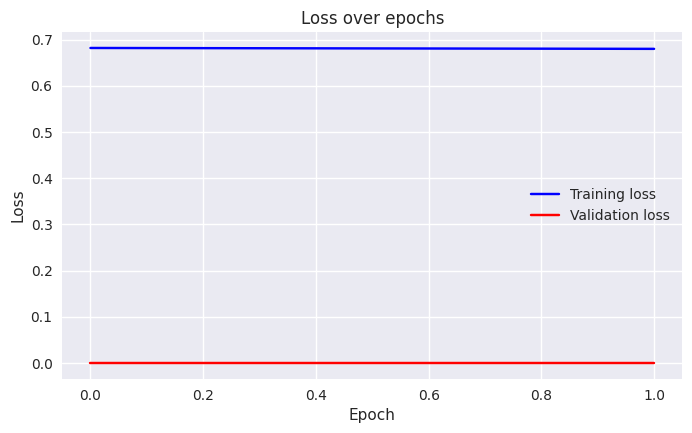

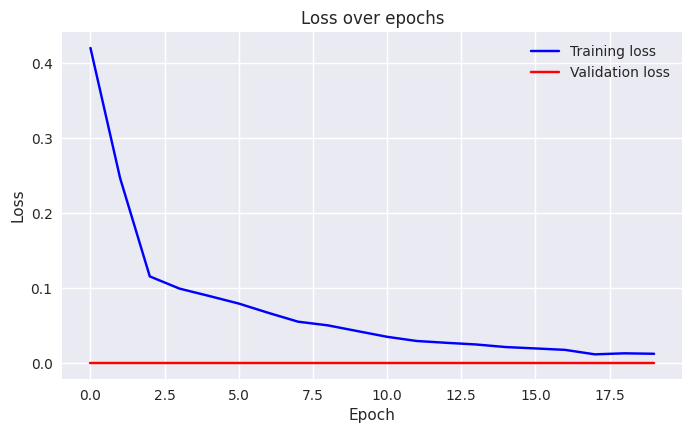

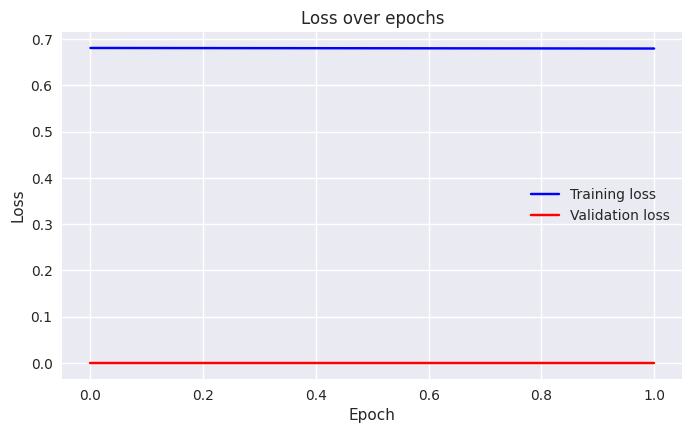

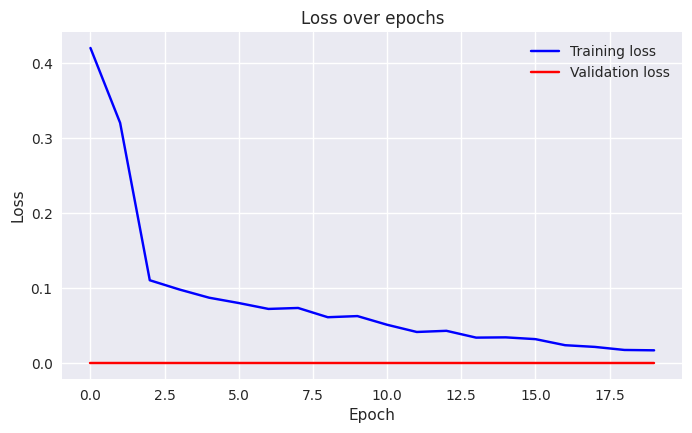

In [219]:
class NullStream:
        @staticmethod
        def write(*_): pass
        @staticmethod
        def flush(*_): pass

def print_to_stdout_and_stream(text, stream:TextIO = NullStream):
        sys.stdout.write(text)
        sys.stdout.flush()
        stream.write(text)
        stream.flush()

NUM_EXPERIMENT_TYPES = 2 # 1 - only 9, 2 - 4+9
NUM_EXPERIMENTS_PER_TYPE = 2
BATCH_SIZE = 32

# DEVICE = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
DEVICE = torch.device("cpu") # No point in using MPS for now :( See https://github.com/pytorch/pytorch/issues/77799

with open('experiments-results.csv', mode='at', encoding="utf-8") as results_stream:
    print_to_stdout_and_stream("experiment_id,\texperiment_type,\tseed,\tbatch_size,\talpha,\ttraining set size,\ttest set size,\tm,\tl,"
                               "\tnum epochs,\tfinal CELoss,\ttotal elements,\ttotal discoveries (ktest),\tv,\tfalse discoveries,\tfdp,"
                               "\tBenchmark num epochs,\tBenchmark final CELoss,\tBenchmark total elements,\tBenchmark total discoveries (ktest),\tBenchmark v,\tBenchmark false discoveries,\tBenchmark fdp\n",
                              results_stream) 
    
    for exp_type in range(2,NUM_EXPERIMENT_TYPES+1):
        
        for i in range(NUM_EXPERIMENTS_PER_TYPE):
            
            # Print to know we started another discovery process
            exp_id = F"{exp_type}-{i}-{datetime.utcnow().strftime('%Y-%m-%d-%H-%M-%S')}"
            print_to_stdout_and_stream(F"{exp_id},"
                                       F"\t{exp_type},"
                                       F"\t{i},"
                                       F"\t{BATCH_SIZE},", results_stream)
            
            discovery_results = run_discovery(i, BATCH_SIZE, exp_type)
            
            print_to_stdout_and_stream(F"\t{discovery_results['alpha']},"
                                       F"\t{discovery_results['training_set_size']},"
                                       F"\t{discovery_results['test_set_size']},"
                                       F"\t{discovery_results['m']},"
                                       F"\t{discovery_results['l']},"
                                       F"\t{discovery_results['num_epochs']['real']},"
                                       F"\t{discovery_results['final_CELoss']['real']},"
                                       F"\t{discovery_results['total_elements']['real']},"
                                       F"\t{discovery_results['total_discoveries']['real']},"
                                       F"\t{discovery_results['v']['real']},"
                                       F"\t{discovery_results['false_discoveries']['real']},"
                                       F"\t{discovery_results['fdp']['real']},"
                                       F"\t{discovery_results['num_epochs']['benchmark']},"
                                       F"\t{discovery_results['final_CELoss']['benchmark']},"
                                       F"\t{discovery_results['total_elements']['benchmark']},"
                                       F"\t{discovery_results['total_discoveries']['benchmark']},"
                                       F"\t{discovery_results['v']['benchmark']},"
                                       F"\t{discovery_results['false_discoveries']['benchmark']},"
                                       F"\t{discovery_results['fdp']['benchmark']}\n", results_stream)
            
            # Reproduceability - save the model used for this discovery process
            torch.save({ 
                'model_state_dict': discovery_results["model"]["real"].state_dict(),
                'optimizer_state_dict': discovery_results["optimizer"]["real"].state_dict(),
                'loss': discovery_results["final_CELoss"]["real"],
                'benchmark_model_state_dict': discovery_results["model"]["benchmark"].state_dict(),
                'benchmark_optimizer_state_dict': discovery_results["optimizer"]["benchmark"].state_dict(),
                'benchmark_loss': discovery_results["final_CELoss"]["benchmark"],
            }, F"{exp_id}.pt")

print("*** All done! ***")